In [58]:
def calculate_table(df, season, output_dir):
    from collections import defaultdict
    import os
        
    team_dict = defaultdict(lambda:0)
    team_home_dict = defaultdict(lambda:0)
    team_away_dict = defaultdict(lambda:0)
    team_table = defaultdict(lambda:defaultdict(lambda:0))

    for i in range(len(df)):

        if df.iloc[i]["visitante"] == df.iloc[i]["vencedor"] or df.iloc[i]["mandante"] == df.iloc[i]["vencedor"]:
            team_dict[df.iloc[i]["vencedor"]] += 3
            if df.iloc[i]["mandante"] == df.iloc[i]["vencedor"]:
                team_table[df.iloc[i]["vencedor"]]["Home_Vict"] += 1
                team_table[df.iloc[i]["visitante"]]["Away_Loss"] += 1
                team_home_dict[df.iloc[i]["mandante"]] += 3
            else:
                team_table[df.iloc[i]["vencedor"]]["Away_Vict"] += 1
                team_table[df.iloc[i]["mandante"]]["Home_Loss"] += 1
                team_away_dict[df.iloc[i]["visitante"]] += 3
        else:
            team_dict[df.iloc[i]["visitante"]] += 1
            team_dict[df.iloc[i]["mandante"]] += 1
            team_away_dict[df.iloc[i]["visitante"]] += 1
            team_home_dict[df.iloc[i]["mandante"]] += 1
            team_table[df.iloc[i]["mandante"]]["Home_Draw"] += 1
            team_table[df.iloc[i]["visitante"]]["Away_Draw"] += 1
            
        
    sorted_teams = sorted(team_dict, key=lambda k: team_dict[k], reverse=True)
    sorted_teams_home = sorted(team_home_dict, key=lambda k: team_home_dict[k], reverse=True)
    sorted_teams_away = sorted(team_away_dict, key=lambda k: team_away_dict[k], reverse=True)
    
    
    
    team_pos_dict = defaultdict(dict)
    team_point_dict = defaultdict(dict)
    
    
    os.makedirs(os.path.join(output_dir,str(season)), exist_ok=True)
    
    f = open(os.path.join(os.path.join(output_dir,str(season)),str(season)+"_table.csv"), "w")
    f.write("Team,Home_Vict,Home_Draw,Home_Loss,Away_Vict,Away_Draw,Away_Loss,Overall_Pla,Home_Pla,Away_Pla\n")
    for t in sorted_teams:
        
        team_table[t]["Overall_Pla"] = sorted_teams.index(t) + 1
        team_table[t]["Home_Pla"] = sorted_teams_home.index(t) + 1
        team_table[t]["Away_Pla"] = sorted_teams_away.index(t) + 1
        
        f.write(",".join([t] + [str(team_table[t][s]) for s in "Home_Vict,Home_Draw,Home_Loss,Away_Vict,Away_Draw,Away_Loss,Overall_Pla,Home_Pla,Away_Pla".split(",")]))
        f.write("\n")
        
        team_pos_dict[t]["Overall"] = sorted_teams.index(t) + 1
        team_pos_dict[t]["Home"] = sorted_teams_home.index(t) + 1
        team_pos_dict[t]["Away"] = sorted_teams_away.index(t) + 1
        
        team_point_dict[t]["Overall"] = team_dict[t]
        team_point_dict[t]["Home"] = team_home_dict[t]
        team_point_dict[t]["Away"] = team_away_dict[t]
        
    
    f.close()

    return sorted_teams, team_pos_dict, team_point_dict


In [59]:
def create_season_heatmap(sorted_teams, df_season, season, output_dir):
    import numpy as np
    from pandas import DataFrame
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os

    %matplotlib inline

    os.makedirs(os.path.join(output_dir,str(season)), exist_ok=True)
    
    matrix_home = np.zeros((len(sorted_teams),len(sorted_teams)))
    matrix_vis = np.zeros((len(sorted_teams),len(sorted_teams)))

    for i in range(len(df_season)):
        
        vis_i = sorted_teams.index(df_season.iloc[i]["visitante"])
        home_i = sorted_teams.index(df_season.iloc[i]["mandante"])

        if df_season.iloc[i]["visitante"] == df_season.iloc[i]["vencedor"]:
            matrix_home[home_i,vis_i] -= 0
            matrix_vis[vis_i,home_i] += 3
        elif df_season.iloc[i]["mandante"] == df_season.iloc[i]["vencedor"]:
            matrix_home[home_i,vis_i] += 3
            matrix_vis[vis_i,home_i] -= 0
        else:
            matrix_home[home_i,vis_i] += 1
            matrix_vis[vis_i,home_i] += 1
            
            
    for t in sorted_teams:
        i = sorted_teams.index(t)
        matrix_home[i,i] = None
        matrix_vis[i,i] = None
            
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            
    df = DataFrame(matrix_home, index=sorted_teams, columns=sorted_teams)

    sns.heatmap(df, ax=axes[0], annot=True, cmap="magma")

    axes[0].set_xlabel("Away Team", fontsize=12)
    axes[0].set_ylabel("Home Team", fontsize=12)
    axes[0].set_title(f"Brasileirao {season} Matrix - Home Games")

    df = DataFrame(matrix_vis, index=sorted_teams, columns=sorted_teams)

    sns.heatmap(df, ax=axes[1], annot=True, cmap="magma")

    axes[1].set_xlabel("Away Team", fontsize=12)
    axes[1].set_ylabel("Home Team", fontsize=12)
    axes[1].set_title(f"Brasileirao {season} Matrix - Away Games")
    
    plt.tight_layout()
    plt.savefig(os.path.join(os.path.join(output_dir,str(season)),str(season)+"_home_and_away_games_heatmap.png"))
    plt.show()

In [ ]:
def create_season_points_placement_plots(points, placement, season, output_dir):
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    
    os.makedirs(os.path.join(output_dir,str(season)), exist_ok=True)
    
    teams = list(placement.keys())
    categories = ['Overall', 'Home', 'Away']

    # Data for Placement
    placement_data = np.array([[placement[team][cat] for cat in categories] for team in teams])

    # Data for Points
    points_data = np.array([[points[team][cat] for cat in categories] for team in teams])

    # Bar width and positioning
    x = np.arange(len(teams))
    width = 0.2
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 12))

    # Plot Placement
    for i, cat in enumerate(categories):
        axes[0].bar(x + i * width, placement_data[:, i], width, label=cat)
    axes[0].set_xticks(x + width, teams, rotation=90)
    axes[0].set_xlabel('Teams')
    axes[0].set_ylabel('Placement (Lower is Better)')
    axes[0].set_title(f'Brasileirao {season} - Placement by Teams')
    axes[0].legend()

    # Plot Points
    for i, cat in enumerate(categories):
        axes[1].bar(x + i * width, points_data[:, i], width, label=cat)
    axes[1].set_xticks(x + width, teams, rotation=90)
    axes[1].set_xlabel('Teams')
    axes[1].set_ylabel('Points')
    axes[1].set_title(f'Brasileirao {season} - Points by Teams')
    axes[1].legend()
    
    plt.savefig(os.path.join(os.path.join(output_dir,str(season)),str(season)+"_points_placement_plot.png"))
    plt.show()


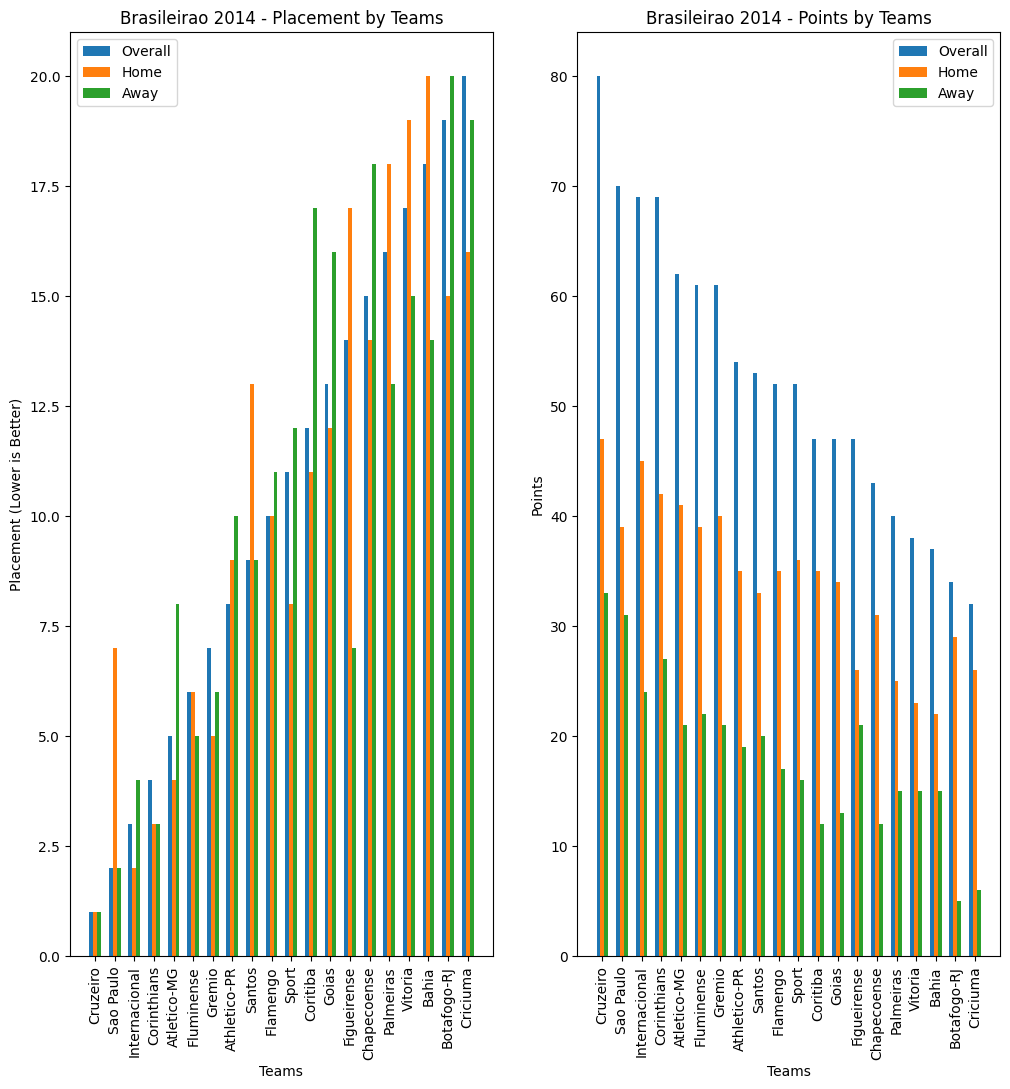

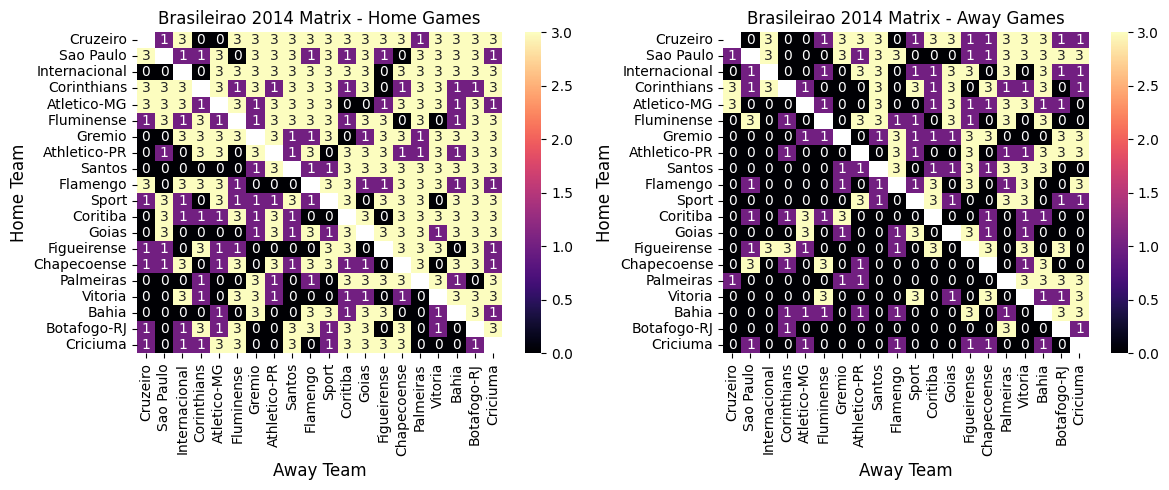

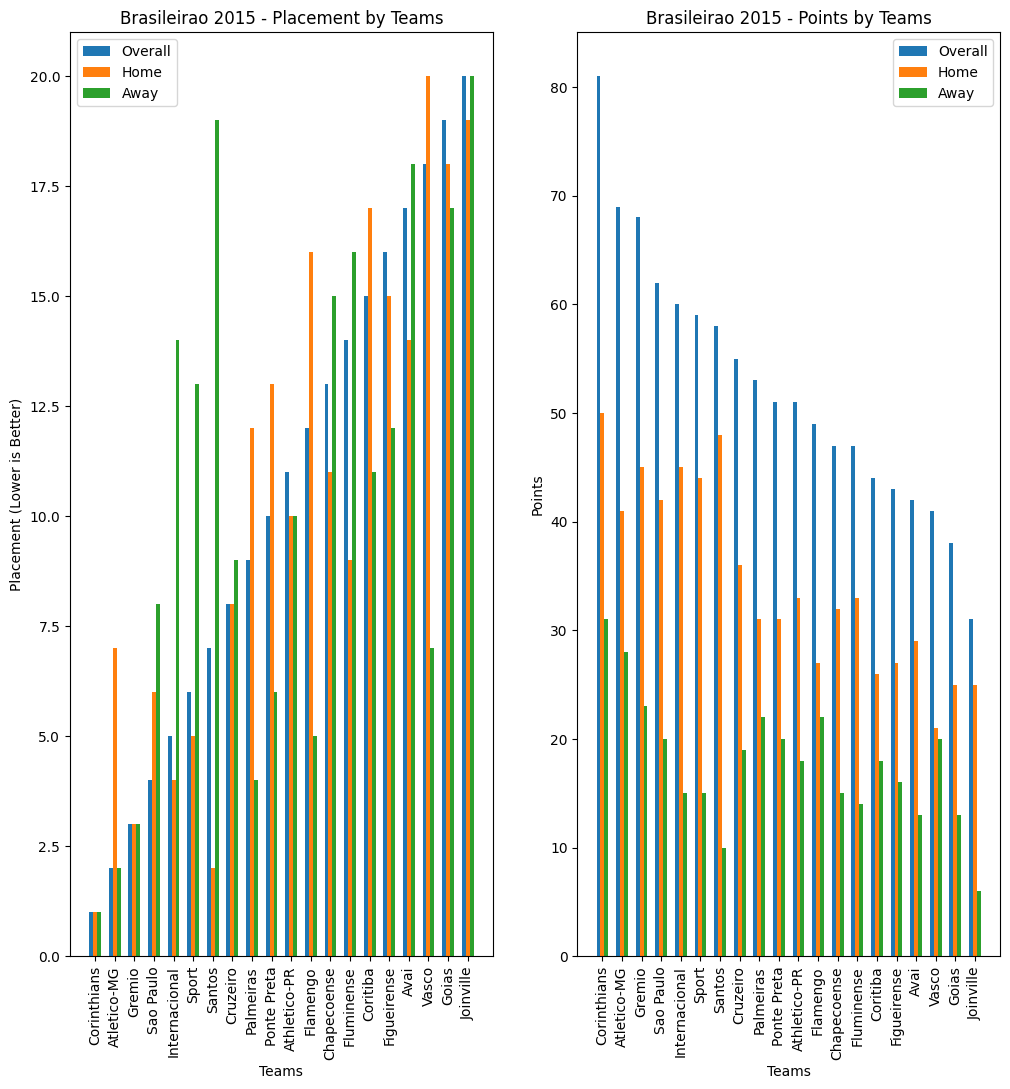

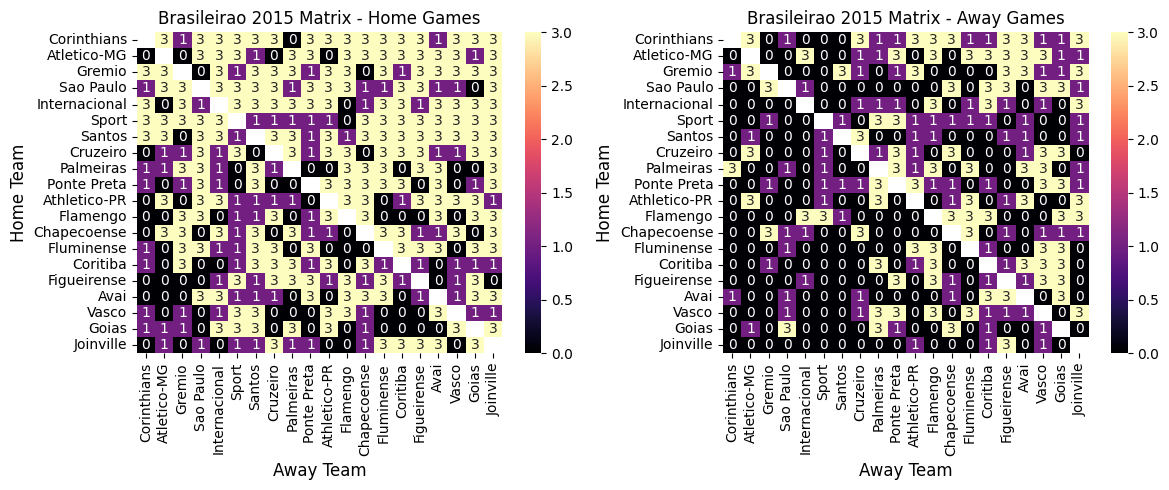

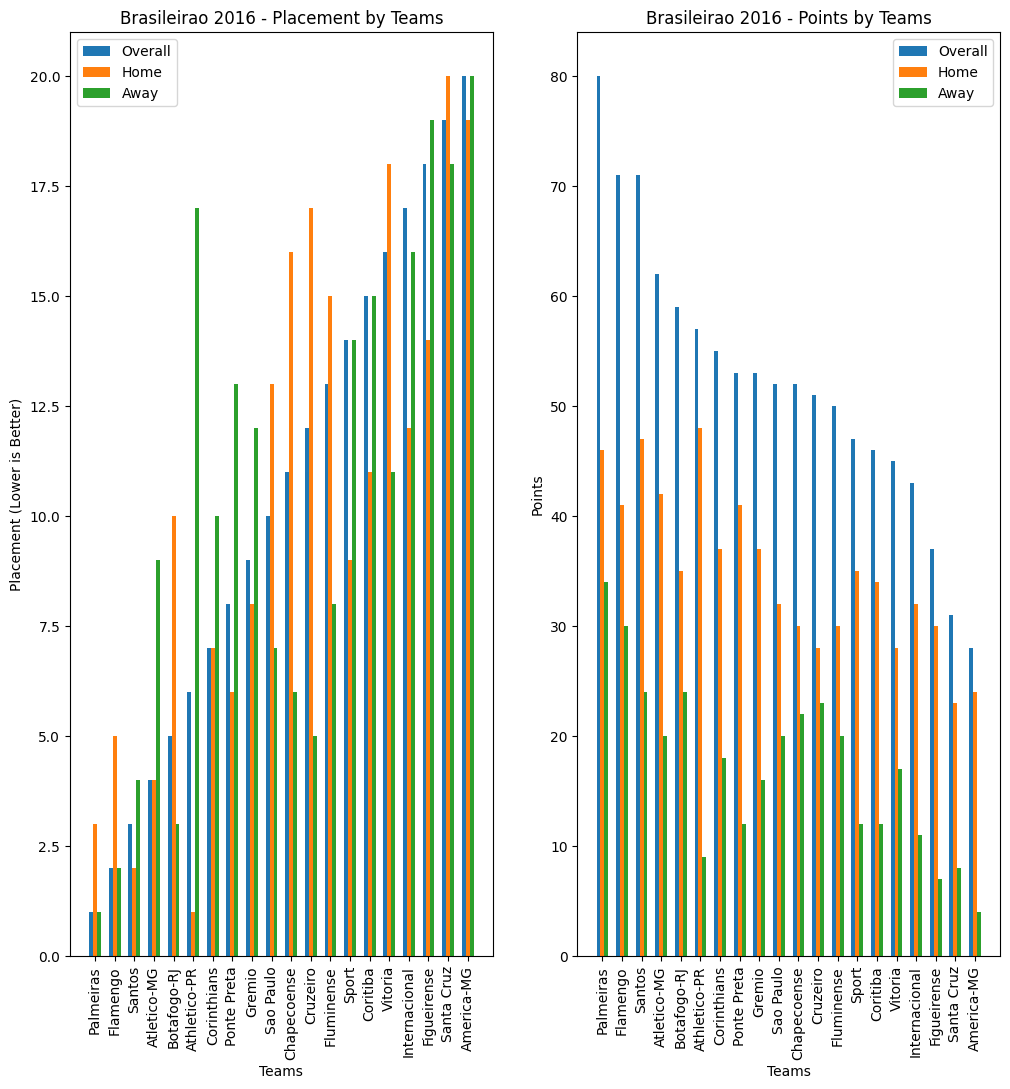

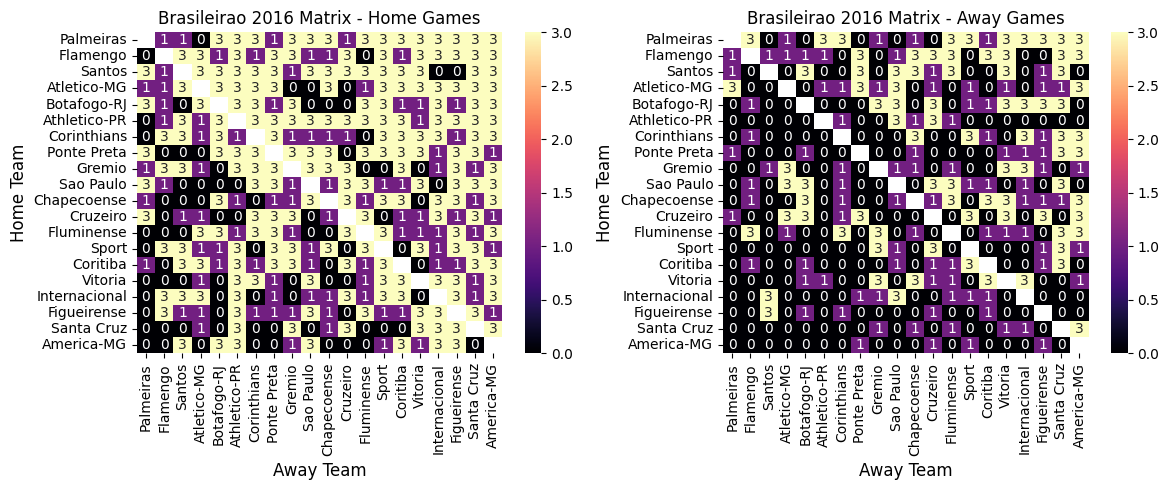

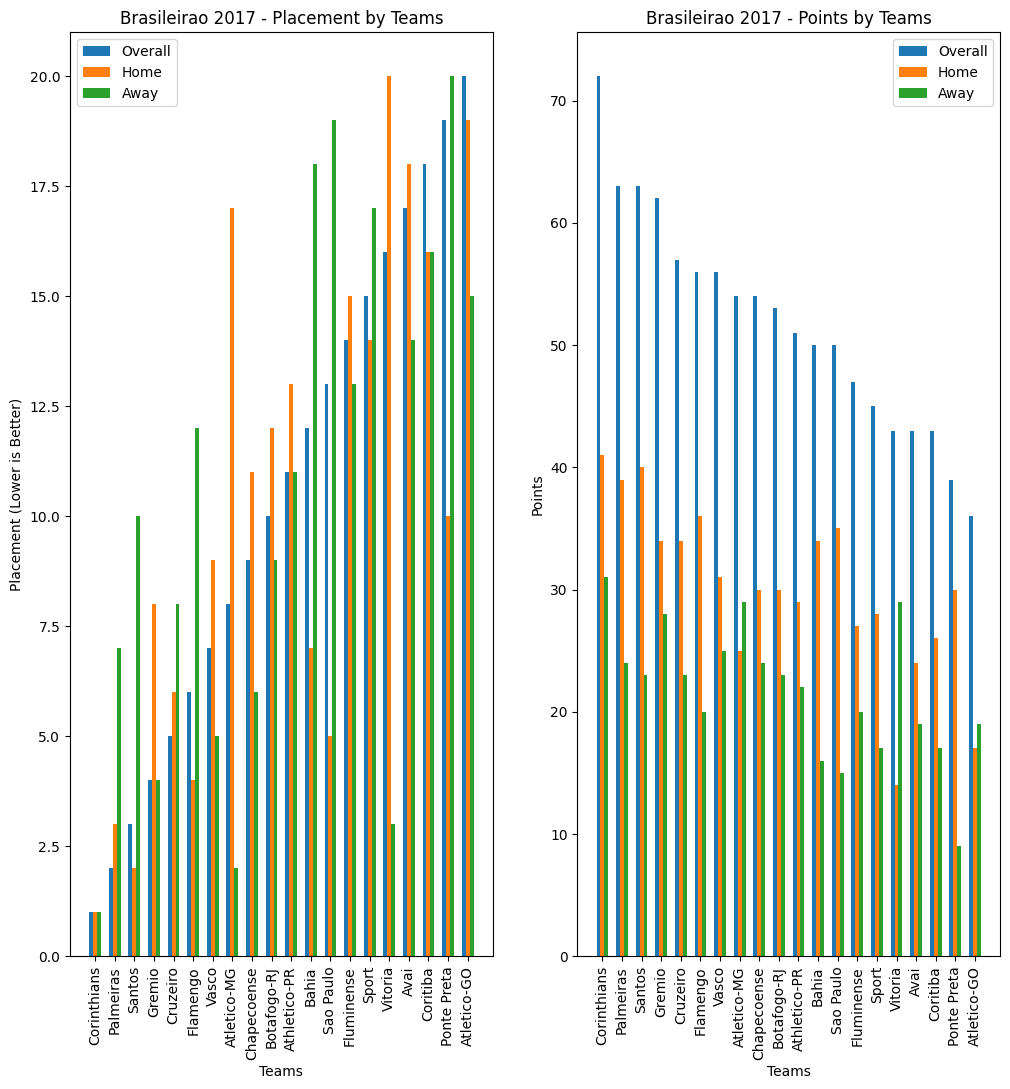

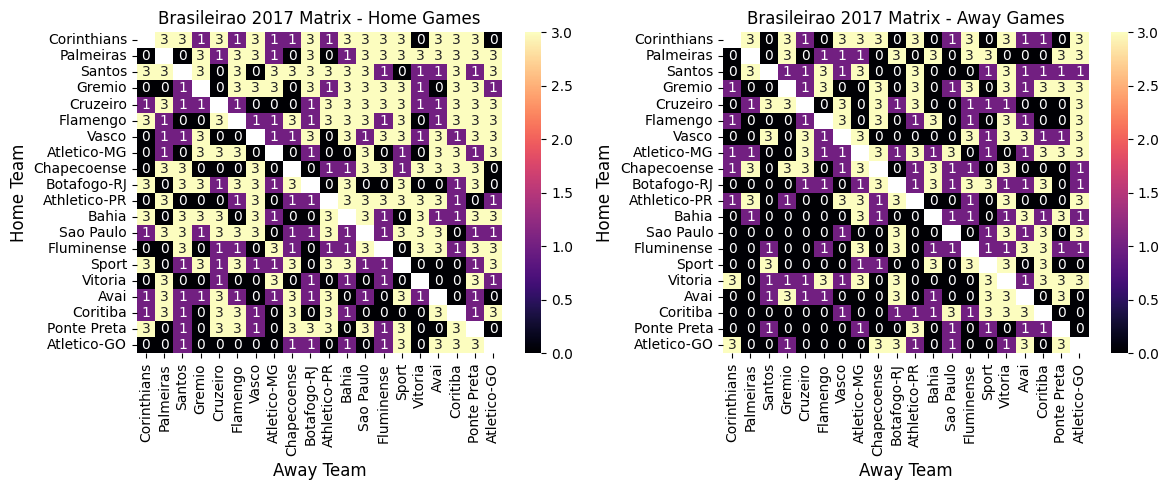

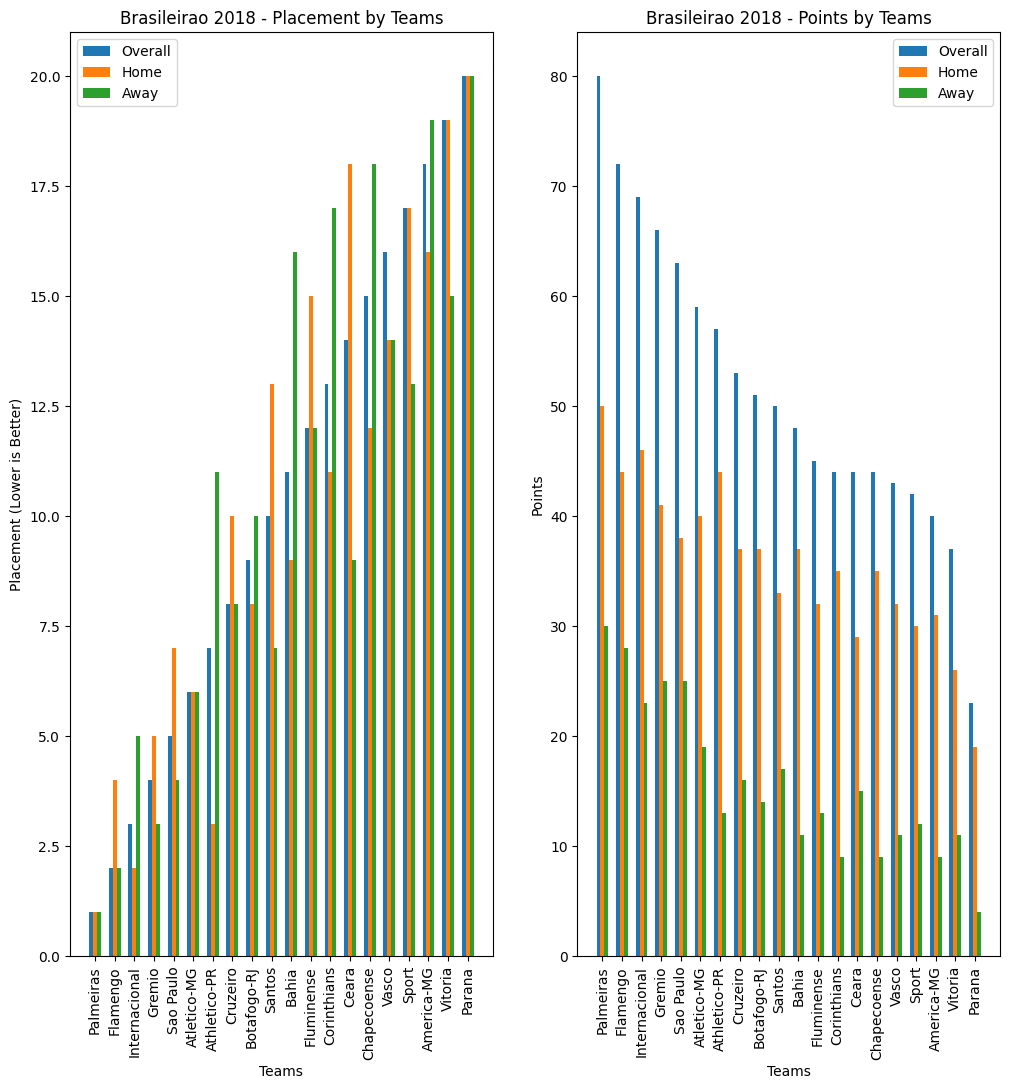

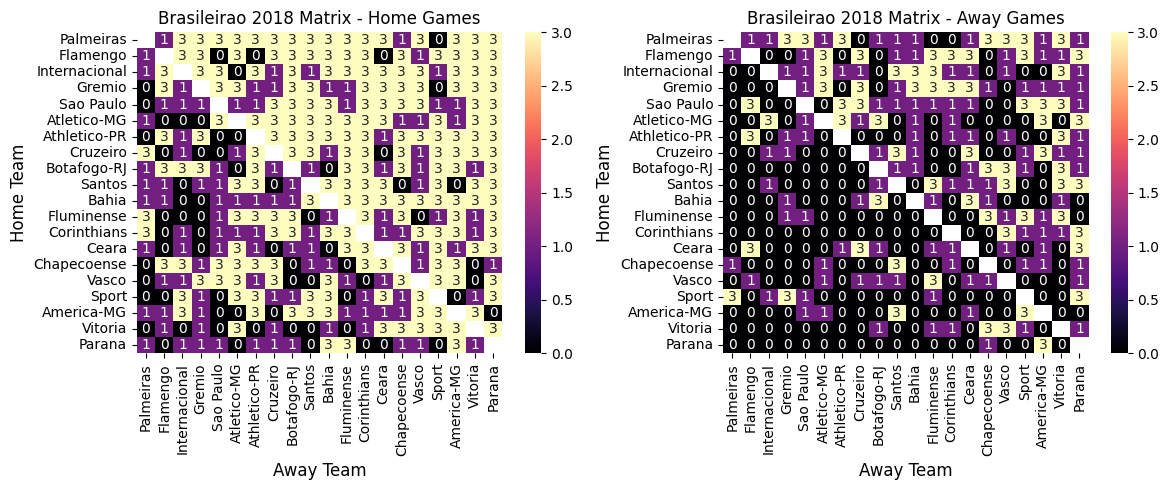

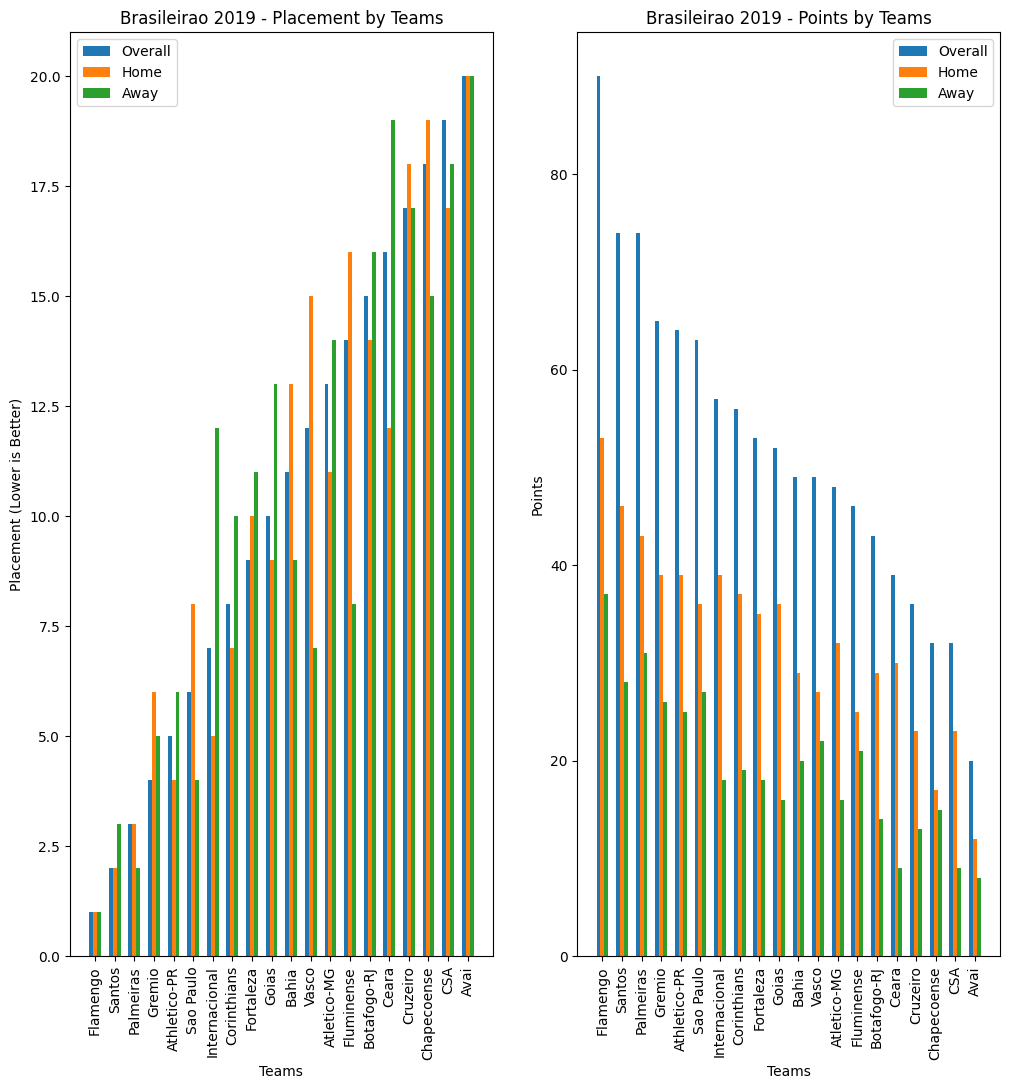

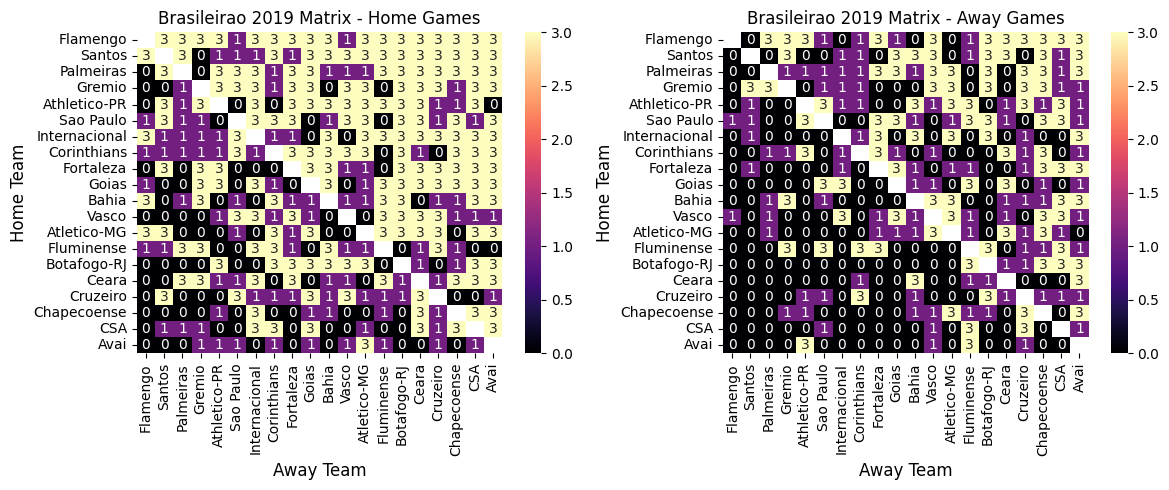

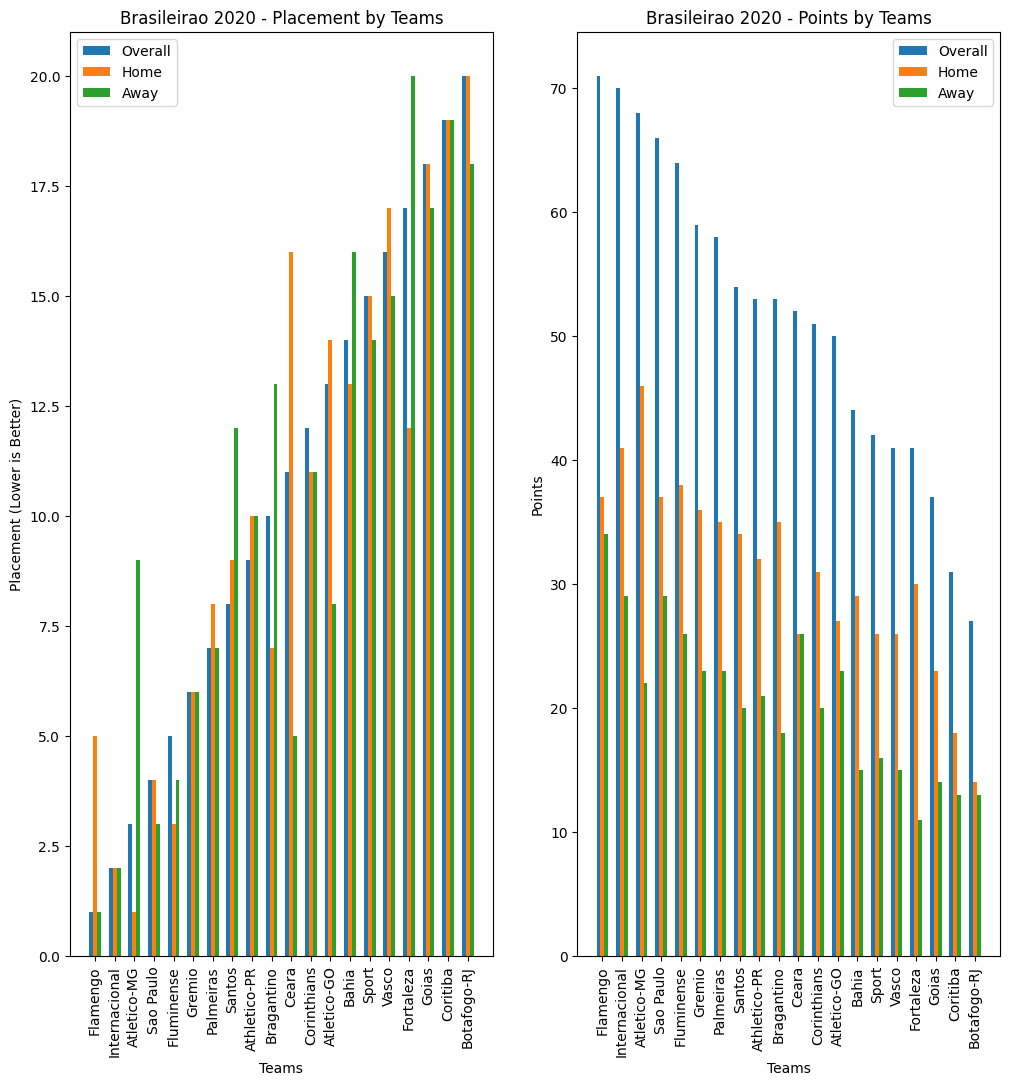

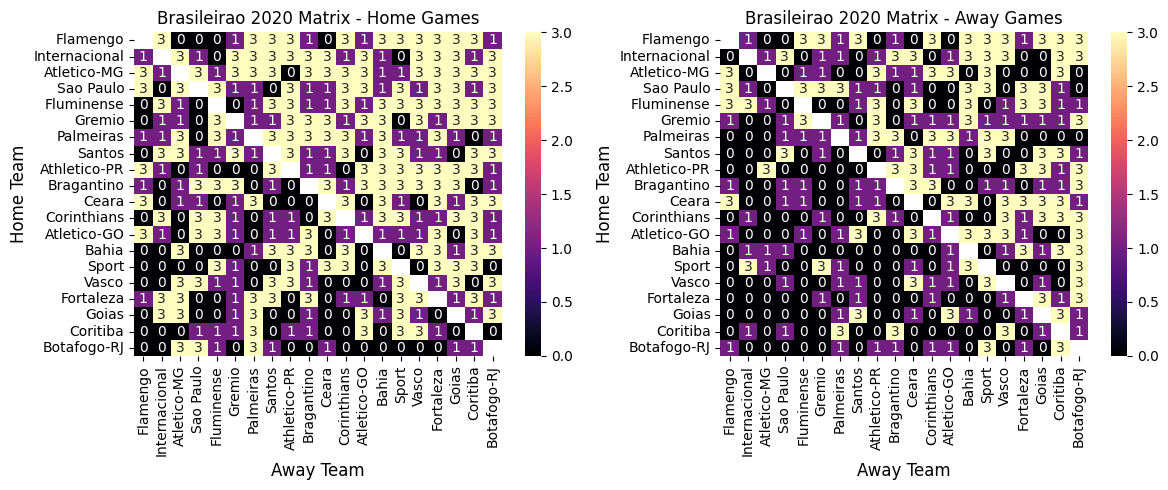

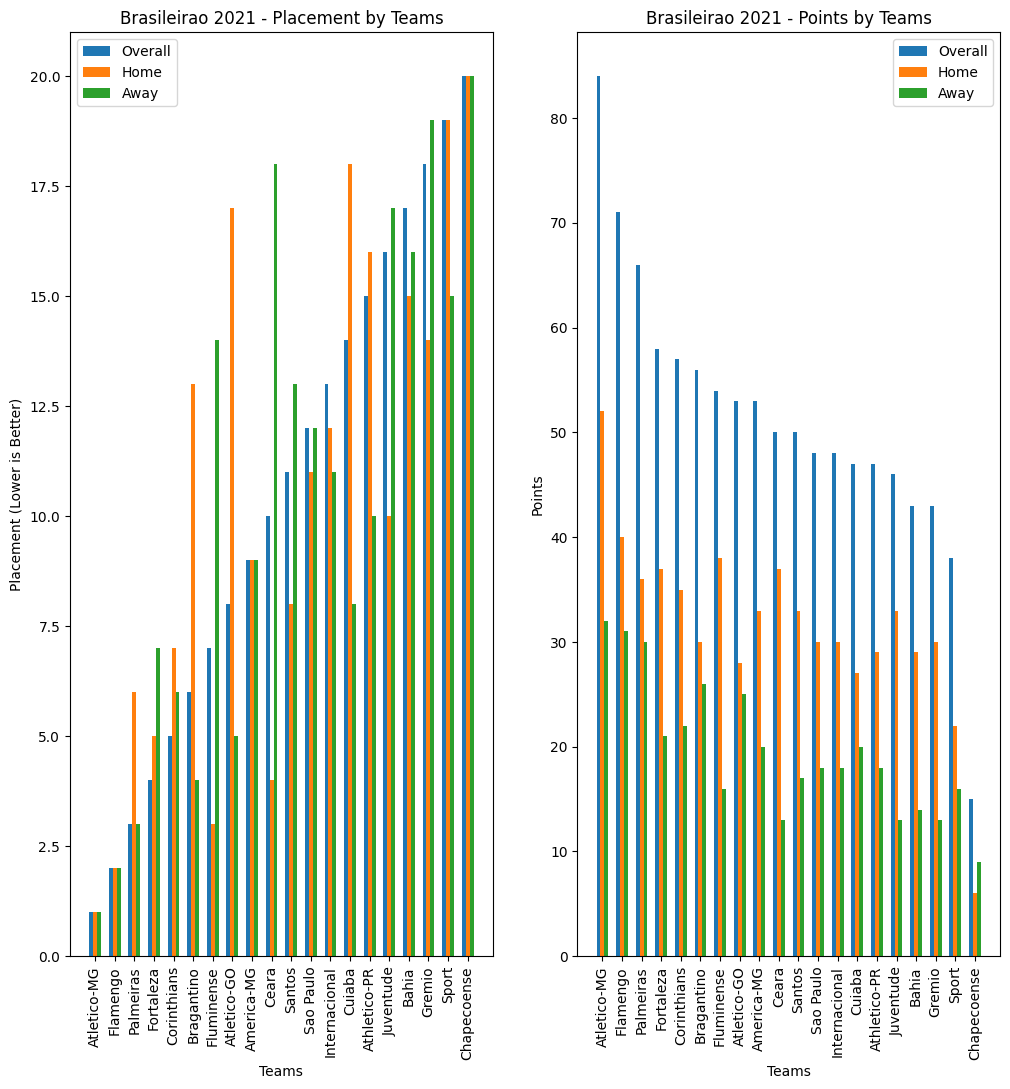

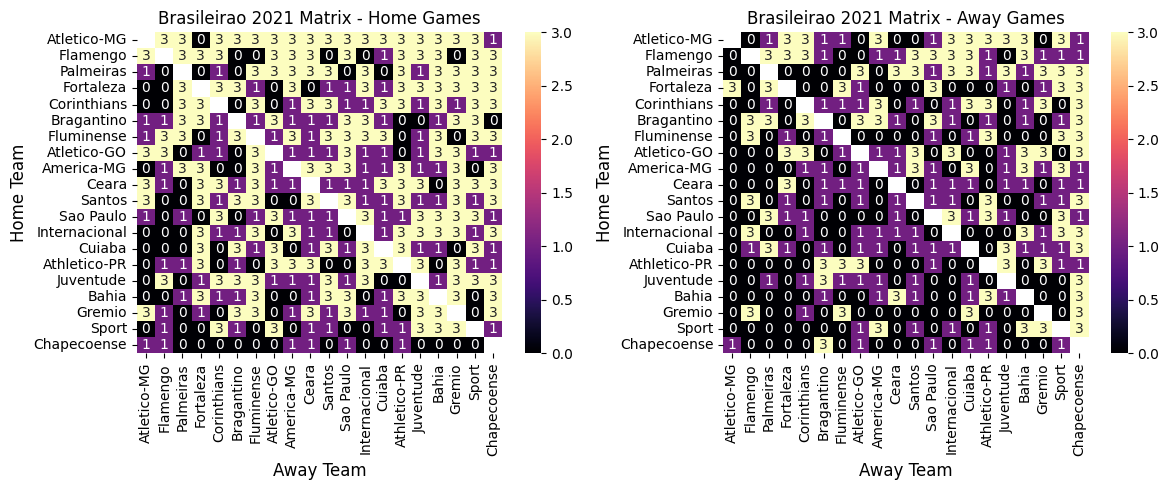

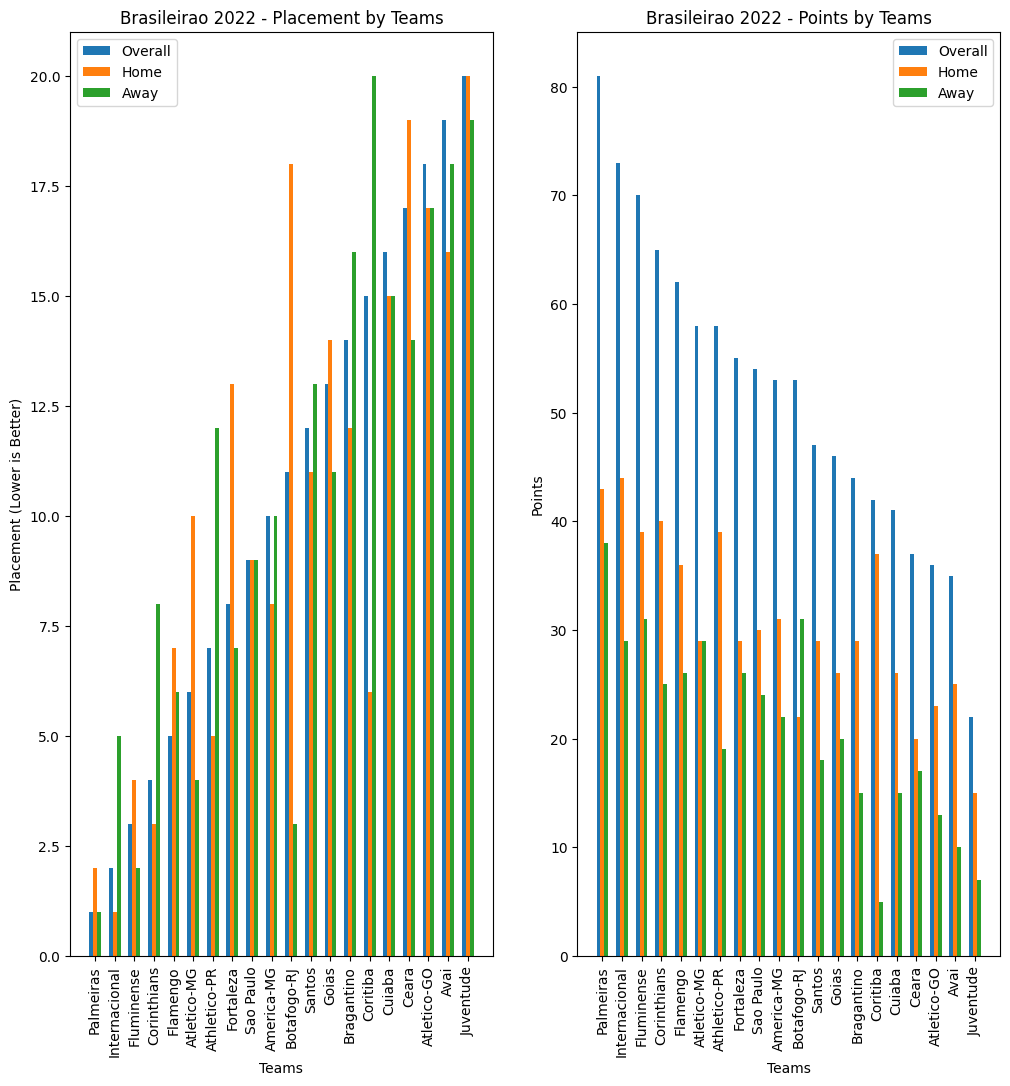

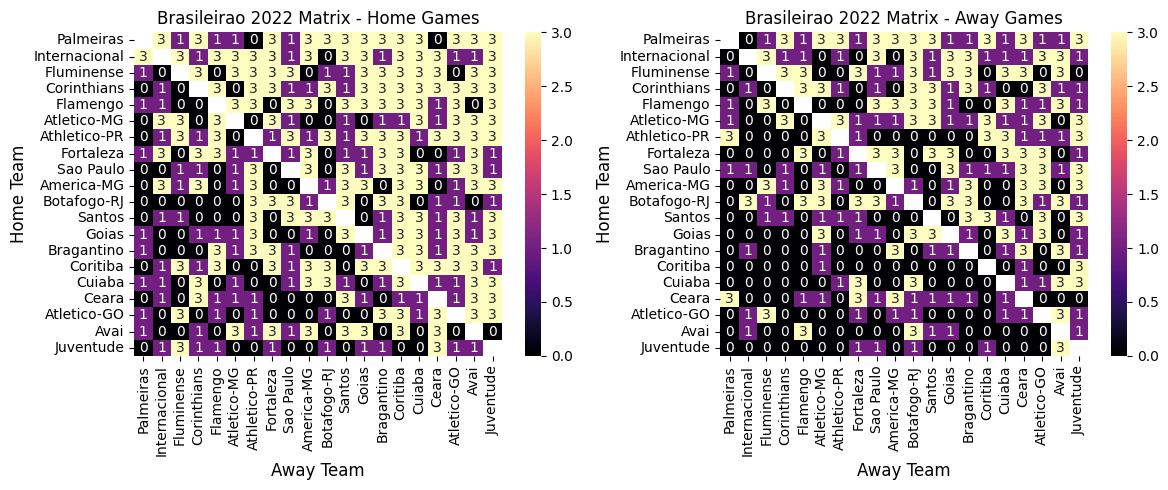

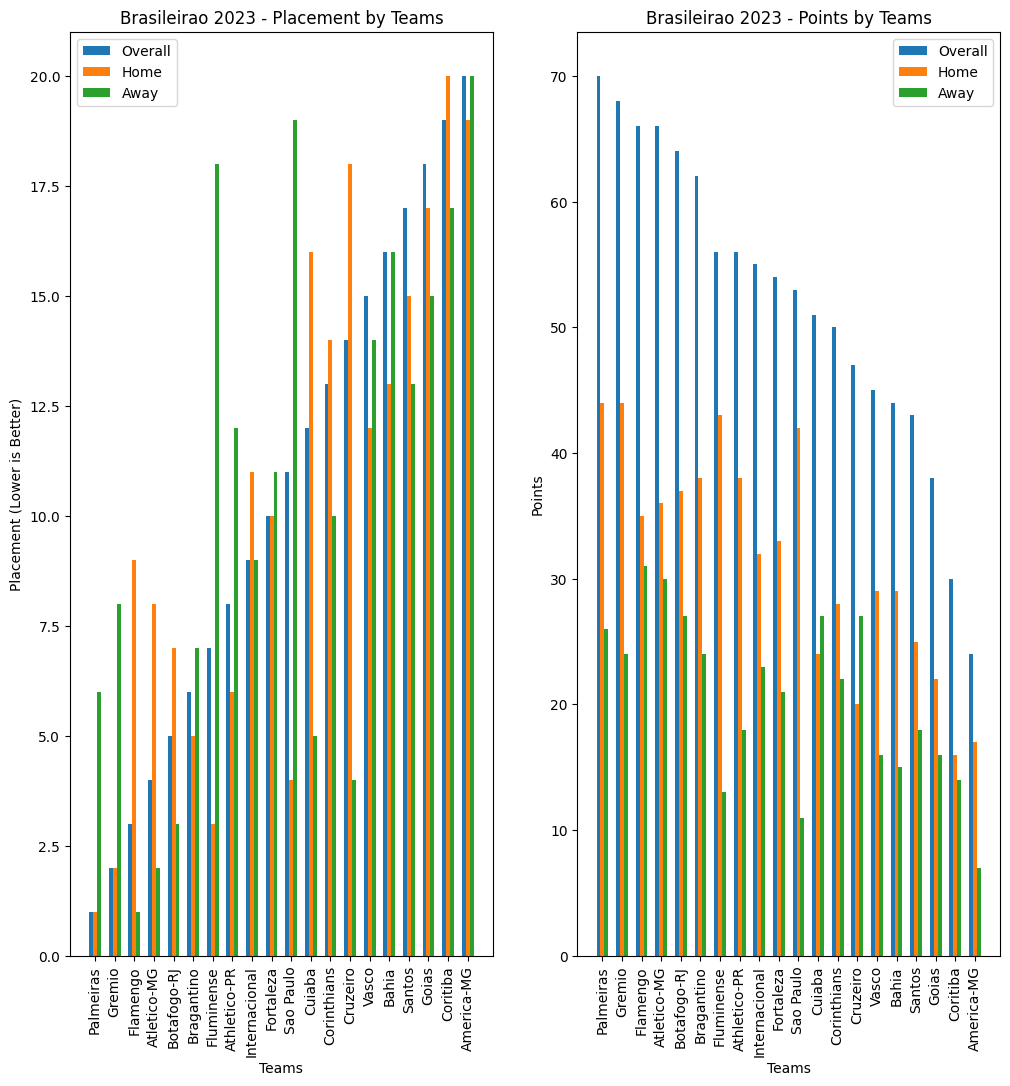

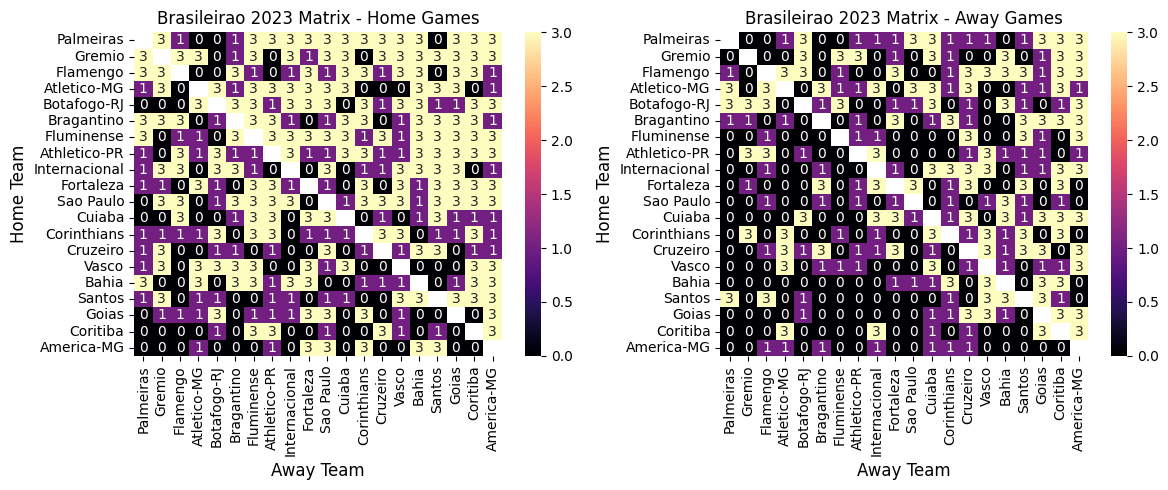

In [61]:
import pandas as pd

df = pd.read_csv('../campeonato-brasileiro-full.csv')
df['data'] = pd.to_datetime(df['data'], dayfirst=True)

for season in range(2014, 2024):
    
    if season == 2020:
        df_season = df[(df['data'] >= pd.Timestamp("2020-08-08")) & (df['data'] <= pd.Timestamp("2021-02-25"))]
    elif season == 2021:
        df_season = df[(df['data'] >= pd.Timestamp("2021-05-29")) & (df['data'] <= pd.Timestamp("2021-12-09"))]
    else:
        df_season = df[(df['data'] >= pd.Timestamp(f"{season}-01-01")) & (df['data'] <= pd.Timestamp(f"{season}-12-31"))]

    sorted_teams, placement, points = calculate_table(df_season, season, ".\\data")

    create_season_points_placement_plots(placement=placement, points=points, season= season, output_dir=".\\data")
    create_season_heatmap(sorted_teams, df_season, season, ".\\data")